### Common Functions

In [17]:
import os

def initialize_bart():
    from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig
    model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
    tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
    return model, tokenizer

def initialize_t5(t5_model):
    from transformers import AutoModelWithLMHead, AutoTokenizer
    model = AutoModelWithLMHead.from_pretrained(t5_model, return_dict=True)
    tokenizer = AutoTokenizer.from_pretrained(t5_model)
    return model,tokenizer

def summarize_t5(text,model,tokenizer):
    # T5 uses a max_length of 512 so we cut the article to 512 tokens.
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=512)
    outputs = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = [tokenizer.decode(g) for g in outputs]
    return summary


def summarize_bart(text,model,tokenizer):
    inputs = tokenizer([text], max_length=1024, return_tensors='pt')
    # Generate Summary
    summary_ids = model.generate(inputs['input_ids'], num_beams=4, max_length=150, early_stopping=True)
    summary = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]
    return summary


def summarize_gpt3(text):
    import openai
    openai.api_key = os.environ.get('GPT3_API_KEY')
    prompt = text + "Summarizing this we can say"
    response = openai.Completion.create(engine="davinci", prompt=prompt, stop="\n\n", temperature=0.7, max_tokens=150)
    return response


In [3]:
#!pip install transformers

### Text Input

In [6]:
text = "In 1848, a revolution led by the educated middle classes was underway. Men and women of the liberal middle class demanded creation of a nation-state on parliamentary principles – a constitution, freedom of the press and freedom of association.A large number of political associations came together in Frankfurt to vote for an all-German National Assembly. On 18 May 1848, 831 elected representatives marched to take their places in the Frankfurt parliament convened in the Church of St Paul.The Constitution drafted for German nation was headed by a monarchy, subject to a Parliament. The Crown was offered to Friedrich Wilhelm IV, King of Prussia but he rejected it and joined other monarchs to oppose the elected assembly. The Middle Class dominated the Parliament and a large number of women participated in liberal movement.Women formed their own political associations, founded newspapers and took part in political meetings and demonstrations, but they were still denied suffrage rights during the election of the Assembly.In the years after 1848, the autocratic monarchies of Central and Eastern Europe began to introduce the changes that had already taken place in Western Europe before 1815. Thus, serfdom and bonded labour were abolished both in the Habsburg dominions and in Russia."


### Checking Different Models

**t5 model**

In [11]:
t5_model = "t5-base"
t5model,t5tokenizer = initialize_t5(t5_model)
summary_t5 = summarize_t5(text,t5model,t5tokenizer)
print(summary_t5)

Some weights of the model checkpoint at t5-base were not used when initializing T5ForConditionalGeneration: ['decoder.block.0.layer.1.EncDecAttention.relative_attention_bias.weight']
- This IS expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by prov

['<pad> in 1848, a revolution led by the educated middle class was underway. men and women of the liberal middle class demanded creation of a nation-state on parliamentary principles – a constitution, freedom of the press and freedom of association.</s>']


**Bart**

In [58]:
bart_model,bart_tokenizer = initialize_bart()
summary_bart = summarize_bart(text,bart_model,bart_tokenizer)
print(summary_bart)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


['In 1848, a revolution led by the educated middle classes was underway. Men and women of the liberal middle class demanded creation of a nation-state on parliamentary principles. A large number of political associations came together in Frankfurt to vote for an all-German National Assembly. The Constitution drafted for German nation was headed by a monarchy, subject to a Parliament.']


**GPT3 model**

In [25]:
summary_gpt3_output = summarize_gpt3(text)
summary_gpt3 = summary_gpt3_output['choices'][0]['text']
summary_gpt3 = " ".join(summary_gpt3.split()[1:])
print(summary_gpt3)

the events of 1848 had become a turning point in the history of Europe. The liberal revolutions had failed, but the changes introduced by them remained. The Industrial Revolution was destroying old production methods and creating a new society. The middle class had become aware of its strength and the working class was growing in numbers. The bourgeoisie was becoming a new ruling class.


**BertSum**

In [51]:
from summarizer import Summarizer
bertsum_model = Summarizer()
result = bertsum_model(text, min_length=20)
summary_bertsum = "".join(result)
print(summary_bertsum)

In 1848, a revolution led by the educated middle classes was underway. The Middle Class dominated the Parliament and a large number of women participated in liberal movement. Thus, serfdom and bonded labour were abolished both in the Habsburg dominions and in Russia.


### Generating Questions from Original Text + Abstractive Text

In [66]:

import spacy


def token_checks(sent):
    root_token = None
    root_token_indx = 0
    verb_cnt = 0
    verb_children = {}
    verb_list = []
    tense = ""
    for indx,token in enumerate(sent):        
        text = token.text
        if token.dep_ == "ROOT":
            root_token = token
            root_token_indx = indx
            tense = token.tag_
            token_children = [child for child in token.children]
            verb_children[token.text] = token_children
        if token.pos_ == "VERB":
            verb_cnt = verb_cnt + 1
            token_children = [child for child in token.children]
            verb_children[token.text] = token_children
            verb_list.append([indx,token])
    token_result = {'root_token':root_token,'root_token_indx':root_token_indx,'verb_cnt':verb_cnt,
                    'verb_list':verb_list,'verb_children':verb_children,"tense":tense}
    return token_result


def fill_in_the_blanks(sent,ent):
    new_sent = sent.text.replace(ent.text,"_____")
    return new_sent


def check_when(sent,ent):
    token_result = token_checks(sent)
    if 'was' in token_result['verb_children']:
        return None
    verb_cnt = 0
    root_token_indx = token_result['root_token_indx']
    token_text = [token.text for token in sent]
    token_text[root_token_indx] = token_result['root_token'].lemma_
    question = " ".join(token_text).lower()
    question = question.replace("on " + ent.text.lower(),"")
    question = question.replace("in " + ent.text.lower(),"")
    question = question.replace(ent.text,"")
    if question.split()[0] in [",","a","an"]:
        question = " ".join(question.split()[1:])
    if question.split()[-1] == ".":
        question = " ".join(question.split()[:-1])
    question = "When did " + question + " ?"
    return question

def check_who(sent,ent):
    subject_flag = -1
    subject_text = ""
    object_text = ""
    verb = ""
    verb_cnt = 0
    for chunk in sent.noun_chunks:
        if ent.text in chunk.text and "nsubj" in chunk.root.dep_:
            subject_flag = 1
        if ent.text in chunk.text and "obj" in chunk.root.dep_:
            subject_flag = 0        
        if "nsubj" in chunk.root.dep_:
            subject_text = chunk.text
        if "obj" in chunk.root.dep_:
            object_text = chunk.text        
        # print(chunk.text, chunk.root.text, chunk.root.dep_,
        #         chunk.root.head.text)
    token_result = token_checks(sent)
    verb = token_result['root_token'].text
    if token_result['verb_cnt'] > 1:
        return None
    if subject_flag == 1:
        question = "Who " + verb + " " + object_text  + "?"
    else:
        question = subject_text + " was " + verb + " by whom ?"
    return question



def check_what_how(sent):
    subject_text = ""
    object_text = ""
    question = None
    for chunk in sent.noun_chunks:
        if "nsubj" in chunk.root.dep_ and subject_text == "":
            subject_text = chunk.text
        if "obj" in chunk.root.dep_ and object_text == "":
            object_text = chunk.text
        # print(chunk.text, chunk.root.text, chunk.root.dep_,
        #         chunk.root.head.text)
    token_result = token_checks(sent)
    root_token_indx = token_result['root_token_indx']
    token_text = [token.text for token in sent]
    tokens_before_root = token_text[:root_token_indx]
    tokens_after_root = token_text[root_token_indx+1:]
    tense = token_result['tense']
    verb = token_result['root_token']
    if tokens_after_root[-1] == ".":
        tokens_after_root = tokens_after_root[:-1]

    joining_words = [verb_text.text for verb_text in token_result['verb_children'][verb.text] if verb_text.pos_=="ADV"]
    ending = " ?"            
    if len(joining_words) > 0:
        ending = " " + " ".join(joining_words) + " ?"
    if "for" in [verb_text.text for verb_text in token_result['verb_children'][verb.text]]:
        if len(joining_words) > 0:
            ending = " " + " ".join(joining_words) + " for ?"
        else:
            ending = " for ?"
    if "was" not in sent.text and "were" not in sent.text:
        if token_result['verb_cnt'] > 1:
            verb2 = token_result['verb_list'][1][1].text        
            if "to" in [verb_text.text for verb_text in token_result['verb_children'][verb2]]:
                # why question
                question =  "Why did " + " ".join(tokens_before_root).lower() + " " + verb.lemma_ + ending.lower()
                return question
    if "was" not in sent.text and "were" not in sent.text:
        if tense == "VBD":
            question = "What did " + " ".join(tokens_before_root).lower() + " " + verb.lemma_ + ending.lower()
            # print(question)
        if tense == "VBN":
            question = "What did " + " ".join(tokens_after_root).lower() + " " + verb.lemma_ + ending.lower()
            # print(question)
    if "was" in sent.text:
        if verb.text != "was":
            question = "What was " + verb.text + " " + "".join(" ".join(tokens_after_root).lower().split(",")[0]) + "?"
        # print(question)
        else:
            question = "What was " + "".join(" ".join(tokens_before_root).lower().split(",")[0]) + "?"
    return question


def generate_questions(text):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    for sent in doc.sents:  
#         print(sent.text)
#         print("=======")
        what_flag = True
        for ent in sent.ents:
            # print(ent.text, ent.start_char, ent.end_char, ent.label_)
            # When questions
            question = None
            if ent.label_ == "DATE":
                if text[:ent.start_char - 1].lower().split()[-1] in ["on","in"]:
                    question = check_when(sent,ent)
                what_flag = False
                if not question:
                    question = fill_in_the_blanks(sent,ent)
                print(question)
            # Who questions
            if ent.label_ == "PERSON":
                question = check_who(sent,ent)
                what_flag = False
                if not question:
                    question = fill_in_the_blanks(sent,ent) 
                print(question)
        # What questions               
        if what_flag:
            question = check_what_how(sent)
            if question:
                print(question)
            # How questions
            # Why questions



In [48]:
generate_questions(summary_bart[0])

In _____, a revolution led by the educated middle classes was underway.
What did men and women of the liberal middle class demand ?
Why did a large number of political associations come together ?
What was headed by a monarchy ?


In [49]:
generate_questions(text)

In _____, a revolution led by the educated middle classes was underway.
What did men and women of the liberal middle class demand ?
Why did a large number of political associations come together ?
When did 831 elected representatives march to take their places in the frankfurt parliament convened in the church of st paul ?
What was headed by a monarchy ?
The Crown was offered by whom ?
What did but he reject ?
What did the middle class dominate ?
In _____, the autocratic monarchies of Central and Eastern Europe began to introduce the changes that had already taken place in Western Europe before 1815.
In the years after 1848, the autocratic monarchies of Central and Eastern Europe began to introduce the changes that had already taken place in Western Europe before _____.


In [50]:
generate_questions(summary_gpt3)

the events of _____ had become a turning point in the history of Europe.
What did , but the changes introduced by them remained fail ?
What was destroying old production methods and creating a new society?
What was become aware of its strength and the working class was growing in numbers?
What was becoming a new ruling class?


In [53]:
generate_questions(summary_bertsum)

In _____, a revolution led by the educated middle classes was underway.
What did the middle class dominate ?


# Reading an image with text and creating questions around it

In [1]:
import cv2
import pytesseract
from pytesseract import Output
import numpy as np


def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def blur_image(image):
    return cv2.medianBlur(image,5)
 

def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]


def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    

def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

def canny(image):
    return cv2.Canny(image, 100, 200)


image = cv2.imread("/home/asha/Downloads/IMG_20201207_172859.jpg")
gray = get_grayscale(image)
thresh = thresholding(gray)
open_img = opening(thresh)

custom_config = r'--oem 3 --psm 6'
data = pytesseract.image_to_string(open_img, lang='eng',config=custom_config)


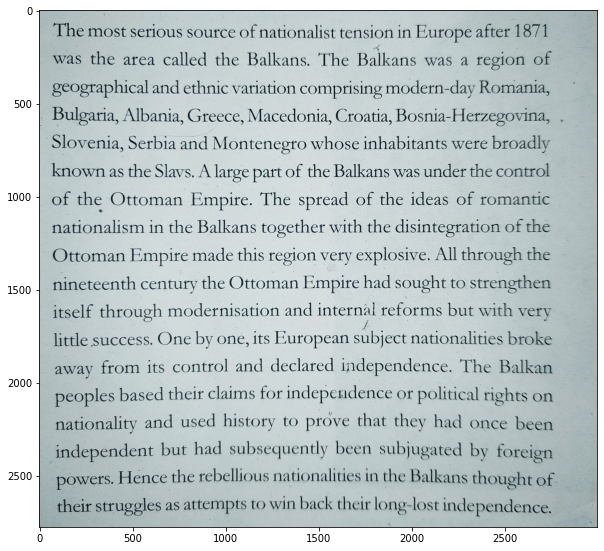

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(image)
plt.show()

In [56]:
import re

def clean_data(txt):
    txt = ''.join(i for i in txt if ord(i)<128)
    txt = txt.replace(".\n"," ")
    txt = txt.replace("\n"," ")
    symbs = "‘-_|\\"
    translator = str.maketrans('', '', symbs)
    txt = txt.translate(translator)
    txt = re.sub(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\xff]', '', txt)
    return txt

data = clean_data(data)
print(data)


The most serious source of nationalist tension in Europe after 1871  was the area called the Balkans. The Balkans was a region of   geographical and ethnic variation comprising modernday Romania,  Bulgaria, Albania, Greece, Macedonia, Croatia, BosniaHerzegovina,  Slovenia, Serbia and Montenegro whose inhabitants were broadly known as the Slavs. A large part of the Balkans was under the control of the Ottoman Empire. The spread of the ideas of romantic nationalism in the Balkans together with the disintegration of the Ottoman Empire made this region very explosive. All through the nineteenth century the Ottoman Empire had sought to strengthen itself through modernisation and internal reforms but with very little success. One by one, its European subject nationalities broke away from its control and declared independence. The Balkan  peoples based their claims for independence or political tights on nationality and used history to prove that they had once been  independent but had subseq

In [60]:
summary_bart2 = summarize_bart(data,bart_model,bart_tokenizer)
print(summary_bart2)

['The Balkans was a region of Romania, Bulgaria, Albania, Greece, Macedonia, Croatia, BosniaHerzegovina, Slovenia, Serbia and Montenegro. A large part of the Balkans was under the control of the Ottoman Empire. The spread of the ideas of romantic nationalism in the Balkans together with the disintegration of the Empire made this region very explosive.']


In [67]:
generate_questions(data)

The most serious source of nationalist tension in Europe after _____  was the area called the Balkans.
What was the balkans?
What was a large part of the balkans?
What did the spread of the ideas of romantic nationalism in the balkans together with the disintegration of the ottoman empire make ?
All through _____ the Ottoman Empire had sought to strengthen itself through modernisation and internal reforms but with very little success.
What did one by one , its european subject nationalities break away ?
What did the balkan   peoples base ?
Why did hence the rebellious nationalities in the balkans think hence ?


In [63]:
generate_questions(summary_bart2[0])

What was the balkans?
What was a large part of the balkans?
What did the spread of the ideas of romantic nationalism in the balkans together with the disintegration of the empire make ?
